# CMIP6 Spatial analysis
This notebook analyses monthly temperature and precipitation anomalies and produces spatial plots for Australia and the globe using CMIP6 historical model output (43 models).  

Notebook last updated on 9 May 2023 by Kate Bongiovanni.

In [1]:
# import relevant libraries
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # used to implement edits of function files
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# define path for files
path = '/g/data/w40/W48_GDATA_MOVED/kb6999'

In [3]:
# import custom functions
import sys 
sys.path.append(f'{path}/Masters_paper') 
import GRL_functions as func

## Read in model data

In [4]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'

In [5]:
# use the read_models function to read in CMIP6 monthly temperature data from 1850-2015
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

55 model paths found and loaded into the dictionary "models"
Model AWI-CM-1-1-MR has different time so is now removed
54 models have been successfully loaded into an xarray


In [6]:
# use the read_models function to read in CMIP6 monthly precipitation data from 1850-2015
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

52 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
51 models have been successfully loaded into an xarray


In [7]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
# check that the models are the same for both variables and if so print True
models_tas.model.equals(models_pr.model)

True

In [8]:
# combine precipitation and temperature into one dataset
models = xr.Dataset({'tas': models_tas.tas, 'pr': models_pr.pr})
# change the pr units into mm/day
models['pr'] = models.pr*86400
models

<xarray.Dataset>
Dimensions:  (lon: 240, lat: 120, time: 1980, model: 50)
Coordinates:
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -89.25 -87.75 -86.25 -84.75 ... 86.25 87.75 89.25
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2014-12-31
  * model    (model) <U17 'CanESM5' 'E3SM-1-1-ECA' ... 'BCC-CSM2-MR' 'BCC-ESM1'
Data variables:
    tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>
    pr       (model, time, lat, lon) float64 dask.array<chunksize=(1, 12, 120, 240), meta=np.ndarray>

model "AWI-CM-1-1-MR" is no longer available

In [9]:
# select out the models that were available at the time
models = models.sel(model= ['ACCESS-CM2','ACCESS-ESM1-5','AWI-ESM-1-1-LR','BCC-CSM2-MR','BCC-ESM1',
                             'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 
                             'CMCC-CM2-HR4', 'CMCC-CM2-SR5' ,'CanESM5', 'E3SM-1-1' ,'E3SM-1-1-ECA' ,'EC-Earth3', 
                             'EC-Earth3-AerChem' , 'EC-Earth3-Veg-LR', 'FGOALS-f3-L' ,'FGOALS-g3', 'FIO-ESM-2-0', 
                             'GFDL-CM4' ,'GFDL-ESM4', 'GISS-E2-1-G' ,'GISS-E2-1-G-CC', 'GISS-E2-1-H' ,'IITM-ESM', 
                             'INM-CM4-8', 'INM-CM5-0' ,'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6' ,'MPI-ESM-1-2-HAM',
                             'MPI-ESM1-2-LR' ,'MRI-ESM2-0', 'NESM3', 'NorCPM1' ,'NorESM2-LM', 'NorESM2-MM',
                             'SAM0-UNICON', 'TaiESM1'])
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 42 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-ESM-1-1-LR' 'BCC-CSM2-MR' 'BCC-ESM1'
 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2' 'CESM2-WACCM'
 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5' 'E3SM-1-1'
 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem' 'EC-Earth3-Veg-LR'
 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4' 'GFDL-ESM4'
 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM' 'INM-CM4-8'
 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1' 'NorESM2-LM' 'NorESM2-MM'
 'SAM0-UNICON' 'TaiESM1']


## Select time slice and regions

In [10]:
# select out time around krakatau eruption
models = models.sel(time = slice('1850-01','1900-01'))

In [11]:
# area weighting 
models_w = models*np.cos(models_tas.lat*(np.pi/180))

## Calculate anomalies

In [12]:
# use functions to calculate the seasonal anomalies for the globe and take the multi model mean 
K_mmm_s_Glob = func.seasonal_anomaly(models_w, '1850-01', '1879-12').mean(dim='model')

In [13]:
# select out gridbox over Australia
K_mmm_s_Aus = K_mmm_s_Glob.sel(lat=slice(-45,-10), lon=slice(110,155))

## Figures

In [14]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [15]:
# set dates and title for eruption and 4 times after
# K_dates winter
K_dates_w = [1883, 1884, 1885, 1886, 1887]
# K_dates_summer
K_dates_s = [1882, 1883, 1884, 1885, 1886]

In [16]:
# winter titles
titles_w = func.seasonal_title_short(K_dates_w, 'winter', 'JJA')
# summer titles 
titles_s = func.seasonal_title_short(K_dates_s, 'summer', 'DJF')
titles_s

['pre-eruption (DJF 1882)',
 '1st summer (DJF 1883)',
 '2nd summer (DJF 1884)',
 '3rd summer (DJF 1885)',
 '4th summer (DJF 1886)']

In [17]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [18]:
# set the modulus maximum for the colour bars
cmax_tas = [-0.8,0.8]
cmax_pr = [-0.8,0.8]

### Australia plots

In [19]:
func=reload(func)

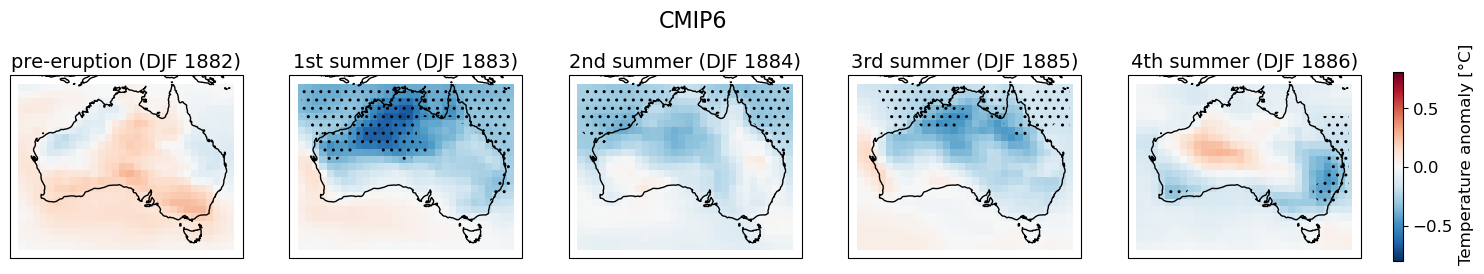

In [20]:
# plot of Aus monthly member mean temperature for summer DJF
label_loc=[7,-0.8]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Aus.tas.sel(season='DJF'), cmax_tas, K_dates_w, titles_s, 
                            'RdBu_r', f'Temperature anomaly [{deg}C]', 1, label_loc)
# add title to figure
fig.suptitle('CMIP6', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(21)
fig.set_figheight(7)

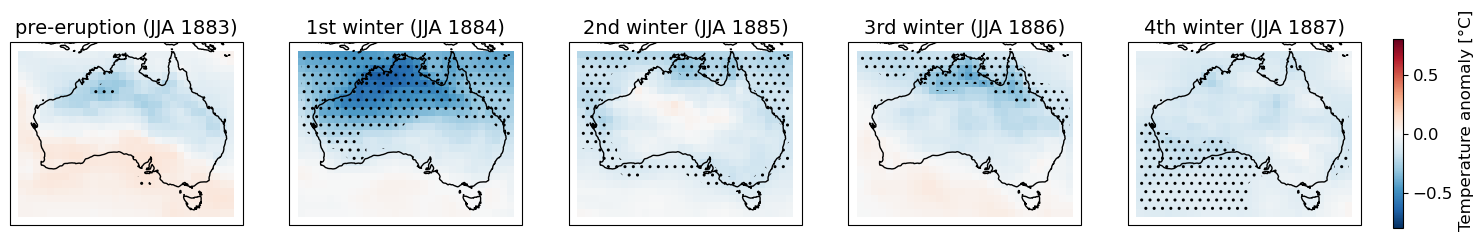

In [21]:
# plot of Aus monthly member mean temperature for winter JJA
label_loc=[7,-0.8]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Aus.tas.sel(season='JJA'), cmax_tas, K_dates_w, titles_w, 
                            'RdBu_r', f'Temperature anomaly [{deg}C]', 1, label_loc)
# add title to figure
# fig.suptitle('CMIP6')

fig.set_figwidth(21)
fig.set_figheight(7)

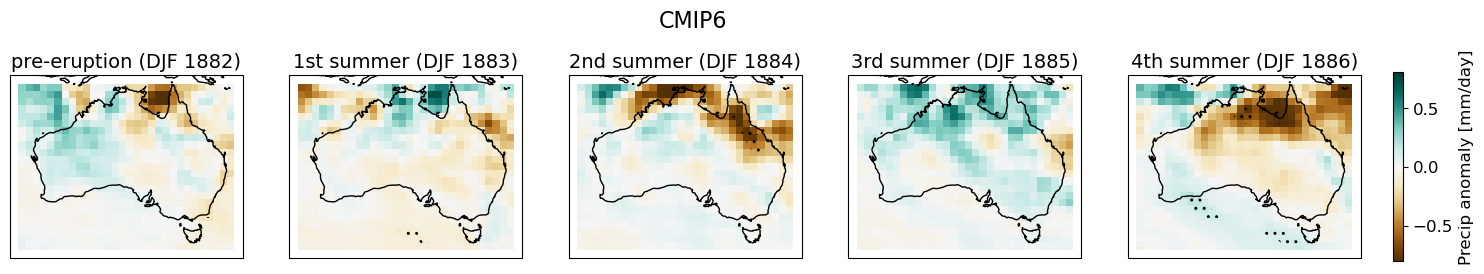

In [22]:
# plot of Aus monthly member mean precipitation for summer DJF
label_loc=[7,-0.8]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Aus.pr.sel(season='DJF'), cmax_pr, K_dates_w, titles_s, 
                            'BrBG', f'Precip anomaly [mm/day]', 1, label_loc)

# add title to figure
fig.suptitle('CMIP6', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(21)
fig.set_figheight(7)

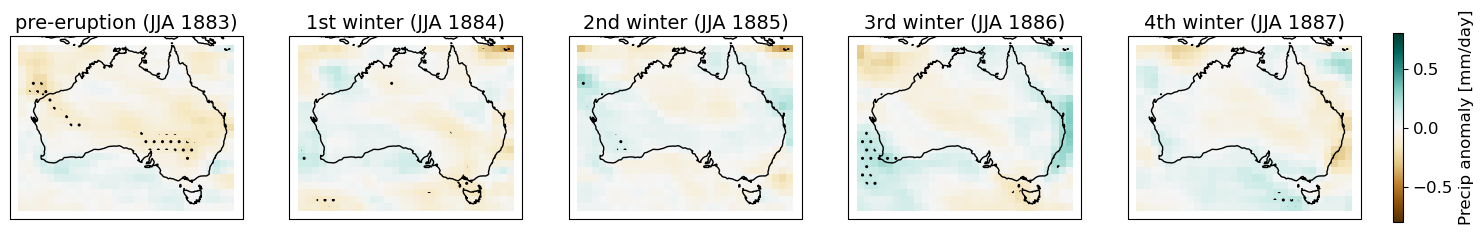

In [23]:
# plot of Aus monthly member mean precipitation for winter JJA
label_loc=[7,-0.8]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Aus.pr.sel(season='JJA'), cmax_pr, K_dates_w, titles_w, 
                            'BrBG', f'Precip anomaly [mm/day]', 1, label_loc)

fig.set_figwidth(21)
fig.set_figheight(7)

### Global plots

In [24]:
# adjust the fontsize of the x and y labels
plt.rc('axes', labelsize=MEDIUM_SIZE)    

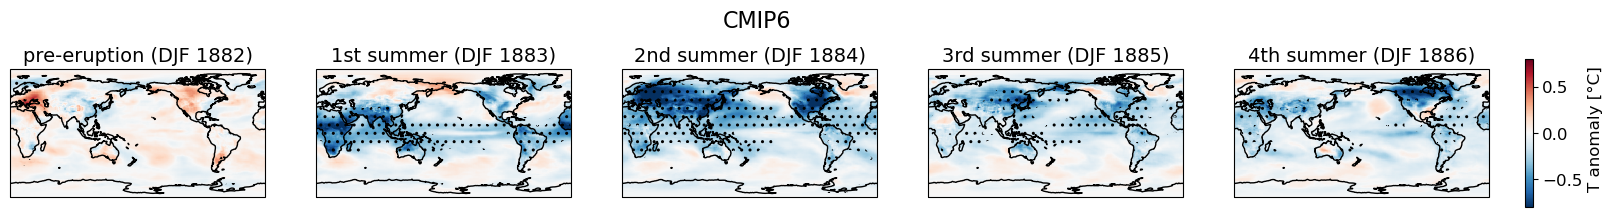

In [25]:
# plot of global monthly member mean temperature for summer DJF
label_loc=[8.5,-0.6]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Glob.tas.sel(season='DJF'), cmax_tas, K_dates_w, titles_s, 
                            'RdBu_r', f'T anomaly [{deg}C]', 1, label_loc)
# add title to figure
fig.suptitle('CMIP6', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(23)
fig.set_figheight(5.5)

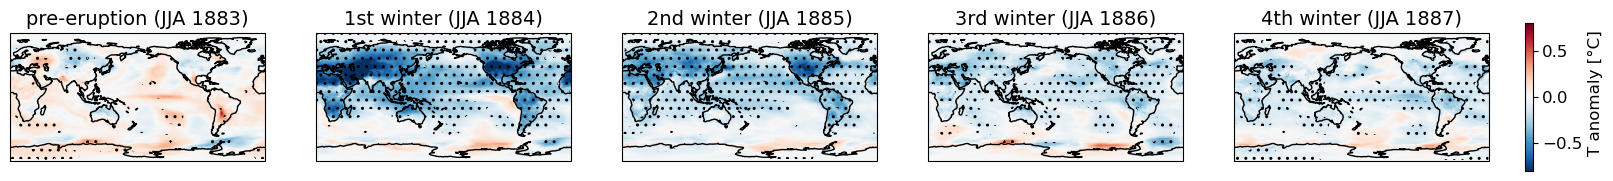

In [26]:
# plot of global monthly member mean temperature for winter JJA
label_loc=[8.5,-0.6]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Glob.tas.sel(season='JJA'), cmax_tas, K_dates_w, titles_w, 
                            'RdBu_r', f'T anomaly [{deg}C]', 1, label_loc)

fig.set_figwidth(23)
fig.set_figheight(5.5)

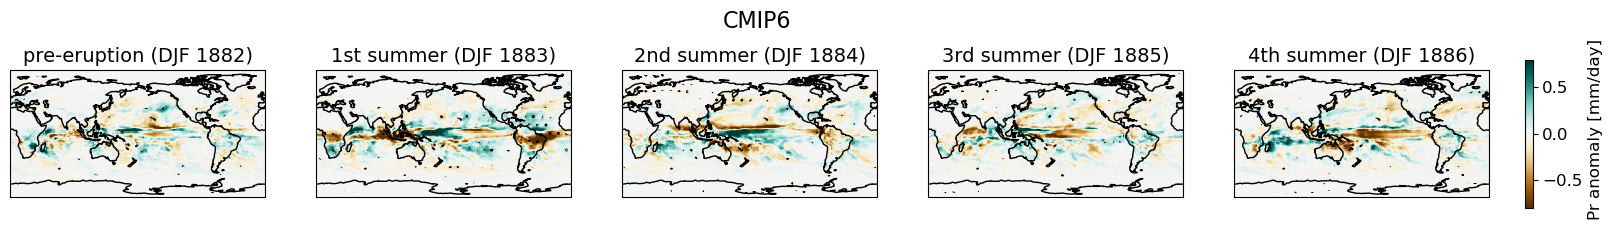

In [27]:
# plot of global monthly member mean precipitation for summer DJF
label_loc=[8.5,-0.9]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Glob.pr.sel(season='DJF'), cmax_pr, K_dates_w, titles_s, 
                            'BrBG', f'Pr anomaly [mm/day]', 1, label_loc)

# add title to figure
fig.suptitle('CMIP6', y=0.72, x=0.45, fontsize=16)

fig.set_figwidth(23)
fig.set_figheight(5.5)

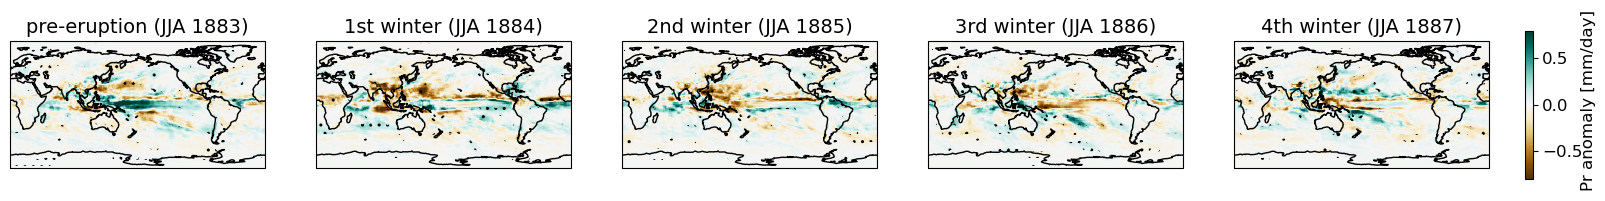

In [28]:
# plot of global monthly member mean precipitation for winter JJA
label_loc=[7.5,-0.9]
fig = func.spatial_plot_cv(1, 5, K_mmm_s_Glob.pr.sel(season='JJA'), cmax_pr, K_dates_w, titles_w, 
                            'BrBG', f'Pr anomaly [mm/day]', 1, label_loc)

fig.set_figwidth(23)
fig.set_figheight(5.5)